# Tools for Error Analysis of Simon's Algorithm
**Scott Johnstun**

*Brigham Young University*

This notebook includes Python code for setting up instances of Simon's Problem and solving it with a quantum circuit and the appropriate classical postprocessing. The quantum circuit can be run on a simulator for ideal results or on an actual quantum computer at IBM for realistic results.

## 1. Initialization of environment
We first need to import modules relating to Qiskit and data visualization.

In [1]:
import numpy as np
from qiskit import *
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Problem Parameters
Simon's problem requires an $n$-bit number $a$ that defines a function $f$ that takes $n$ bit numbers to ($n-1$)-bit numbers such that, for any $n$-bit numbers $x$ and $y$, $f(x) = f(y)$ if and only if $x = y \oplus a$. We need to define an $a$ value to embed into the circuit. Our goal will then be to recover it from the circuit using Simon's algorithm.

Once this value for $a$ is decided, we need to construct an $(n-1)\times n$ matrix $\mathbb{U}$ with entries in $\mathbb{Z}_2$ whose kernel is spanned by the binary expansion $\mathbf{a}$ of the number $a$. Construction of this matrix has proven difficult to reliably automate, so we have provided some example $a$ values and $\mathbb{U}$ matrices for a few $n$ values.

Note that we store the $a$ values as $n$-bit strings of 0s and 1s. This is to ensure that they match up with the readout of the circuit.

We used 16 different $a$ values for the $n=6$ circuit. These values and matrices that correspond are zipped up in a list of pairs of the value and its corresponding matrix.

In [51]:
a_values = [['011101', '100110', '100111', '011110', 
             '010110', '001001', '111101', '010111', 
             '010101', '001110', '001001', '101000', 
             '101101', '001100', '001000', '011111']]
a_values.append(np.array([[1,0,1,1,1,0],[1,0,0,0,0,0],[0,0,0,0,1,0],[0,1,0,1,1,0],[0,0,0,1,0,1]]))
a_values.append(np.array([[0,0,0,1,1,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[1,0,0,1,0,0],[0,0,0,0,0,1]]))
a_values.append(np.array([[1,0,0,1,1,1],[1,0,0,1,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,1]]))
a_values.append(np.array([[1,0,0,0,0,0],[0,1,1,0,0,0],[0,0,1,1,0,1],[0,0,0,0,0,1],[0,1,0,0,1,0]]))
a_values.append(np.array([[1,0,0,0,0,0],[0,0,1,0,0,0],[0,0,0,0,0,1],[0,1,0,1,0,0],[0,0,0,1,1,0]]))
a_values.append(np.array([[1,1,0,1,1,0],[0,0,1,0,0,1],[0,1,0,0,0,0],[0,0,0,1,0,0],[1,0,0,0,0,0]]))
a_values.append(np.array([[1,1,0,1,0,1],[0,0,0,0,1,0],[1,0,1,0,1,0],[1,0,0,0,0,1],[0,0,0,1,0,1]]))
a_values.append(np.array([[0,1,0,1,1,1],[1,0,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,1],[0,0,1,1,1,0]]))
a_values.append(np.array([[1,0,1,0,0,0],[0,0,1,0,0,0],[0,0,0,0,1,0],[0,0,1,1,1,1],[1,1,1,1,1,0]]))
a_values.append(np.array([[1,1,0,0,0,0],[0,0,0,0,0,1],[0,1,0,0,0,0],[0,0,1,1,0,1],[0,1,0,1,1,0]]))
a_values.append(np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,1,0,0,1]]))
a_values.append(np.array([[1,0,1,0,0,0],[0,1,0,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]))
a_values.append(np.array([[1,0,1,0,0,0],[0,0,0,1,0,1],[0,1,0,0,0,0],[0,0,0,0,1,0],[1,0,0,0,1,1]]))
a_values.append(np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1],[0,0,1,1,0,0]]))
a_values.append(np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]))
a_values.append(np.array([[1,0,0,0,0,0],[0,1,0,1,0,0],[0,0,1,0,1,0],[0,0,0,1,1,0],[0,1,0,1,1,1]]))
a_value_pairs = list(zip(a_values[0],a_values[1:17]))

We have one $a$ value for the $n=3$ circuit: $a=\mathtt{111}$.

In [3]:
a_3 = '111'
matrix_3 = np.array([[0,1,1],
                     [1,0,1]])

And finally, we have one $a$ value for the $n=8$ circuit: $a=\mathtt{1000\ 0001}$

In [4]:
a_8 = [1,0,0,0,0,0,0,1]
matrix_8 = np.array([[1,0,0,0,0,0,0,1],
                   [0,1,0,0,0,0,0,0],
                   [0,0,1,0,0,0,0,0],
                   [0,0,0,1,0,0,0,0],
                   [0,0,0,0,1,0,0,0],
                   [0,0,0,0,0,1,0,0],
                   [0,0,0,0,0,0,1,0]])

## 3. Constructing the Circuit
With $a$ and $\mathbb{U}$ defined above, we can insert $U_f$ into the circuit. $U_f$ is the unitary operation that calculates $f$ based on the input register and stores the result on the output register. It is constructed from a series of $cX$ gates whose connectivity is determined by the corresponding $\mathbb{U}$ matrix.  

Simon's algorithm first requires $n$ Hadamard gates on the input register. After this, $U_f$ is applied. We then measure the output register and also apply another set of $n$ Hadamard gates on the input register. The order of these two operations does not affect the outcome of the algorithm. Finally, the input register is measured. Note that the value of the measurement of the output register is irrelevant to the problem of finding $a$, so we store the $n-1$ bits from this measurement on the same $n$-bit classical register that we store the final measurement of the input register on. This means that the measurement of the input register overwrites the measurement of the output register. 

In [10]:
# Function to translate a U matrix into a series of cX gates that will perform U_f on a circuit.
def build_Uf(circuit, matrix):
    (k,n) = np.shape(matrix)
    for out in range(k):
        for inp in range(n):
            if matrix[out][inp] == 1:
                circuit.cx(n-1-inp,n-2-out+n)
    return circuit

# Function to build and return a circuit that performs the quantum operations of Simon's algorithm.
# Takes in an n value and a U matrix as parameters.
# Has an option to include barriers between parts of the circuit; these barriers can help
#  in separating algorithmic steps for clearer understanding, but have no other function.
def build_circuit(n, matrix, barriers=False):
    input_register = QuantumRegister(n, 'input')
    output_register = QuantumRegister(n-1, 'output')
    cregister = ClassicalRegister(n, 'cregister')
    circuit = QuantumCircuit(input_register, output_register, cregister)
    #H gate on every qubit in input register
    for i in range(n):
        circuit.h(i)
    if barriers:
        circuit.barrier(input_register)
        circuit.barrier(output_register)
    #function that Implements Uf with CNOT gates
    build_Uf(circuit, matrix)
    if barriers:
        circuit.barrier(input_register)
        circuit.barrier(output_register)
    #Now measure the output qregister
    for i in range(n-1):
        circuit.measure(output_register[i], cregister[i])
    if barriers:
        circuit.barrier(output_register)
    # at this point, the qubits are in a superposition of exactly two states
    # so we apply H to every input qubit and them measure it
    for i in range(n):
        circuit.h(i)
    if barriers:
        circuit.barrier(input_register)
    for i in range(n):
        circuit.measure(input_register[i], cregister[i])
    return circuit

Let's draw a circuit to see what it looks like. You can manually check that the connections between qubits in the input and output registers align with those in the $\mathbb{U}$ matrix we created for $n=3$.

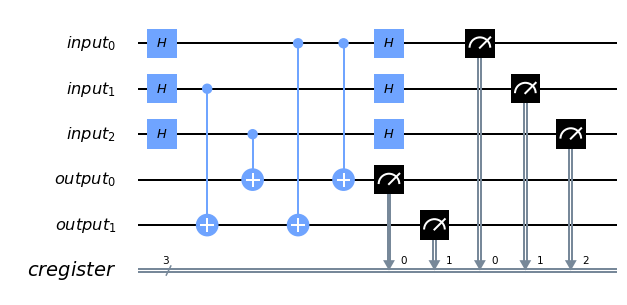

In [8]:
build_circuit(3, matrix_3, barriers=True).draw(output='mpl', plot_barriers=False)

Now we can run the circuit to test it out. First we need to decide whether to use a simulator or an actual quantum computer as our backend. This is controlled by the $\mathtt{real\_computer}$ variable. $\mathtt{backend5}$ should be used for the $n=3$ case, as it is less error-prone than the larger computer. 

In [91]:
real_computer = True
if real_computer:
    IBMQ.load_account()
    provider = IBMQ.get_provider(group='open')
    backend = provider.get_backend('ibmq_16_melbourne')
    backend5 = provider.get_backend('ibmq_ourense')
else:
    backend = Aer.get_backend('qasm_simulator') 

We also need to set the parameters of the circuit to use, such as the size, the $\mathbb{U}$ matrix to use, and $m$, the number of shots to perform.

In [14]:
n = 3
matrix = matrix_3
m = 6

circuit = build_circuit(n, matrix)

Now we create the job on the backend and execute it:

In [15]:
job = execute(circuit, backend, shots=m, memory=True)
result = job.result()

We can figure out what values were read out from the circuit. In perfect conditions, these should all be numbers $z$ that satisfy $z \cdot a \equiv 0$ (mod 2) 

In [16]:
state = result.get_counts(circuit)
print(state)

{'101': 2, '110': 1, '011': 3}


## 4. Classical Postprocessing
We can then use these counts to determine what $a$ should be. This is the classical postprocessing required for Simon's algorithm.

Each readout defines a modulo 2 equation that helps us determine what $a$ is. If we have at least $n$ different readouts (and no incorrect readouts), then we can determine $a$. We were unable to find or efficiently develop a modulo-2 equation solver, so we use the brute-force method of testing all $2^n$ possible $a$ values and manually computing $z \cdot a$ for each $a$ and $z$ value, then we select on the $a$ value(s) that work. Note that if we have found multiple possible $a$ values, then we did not obtain enough different $z$ value to uniquely determine $a$.

Here is the code that performs that brute-force operation.

In [28]:
def find_a(state):
    # Figure out n from the state information given.
    # This is a little clunky, but it prevent us from needing
    # to pass in n each time we call the function.
    n_ = len(next(iter(state)))
    # A list to hold the possible a values that could work
    possible_as = []
    for i in range(1,2**n):
        it_works = True
        for key in state:
            if bitwise_dot(i, int(key,2)) == 1:
                it_works = False     
        if it_works:
            possible_as.append("{0:0{digits}b}".format(i, digits=n_))
    return possible_as

# bitwise_dot performs the dot product mod 2 for use in the find_a function
def bitwise_dot(a, b, strings=False):
    if strings:
        a_str = a
        b_str = b
    else:
        if a < b:
            return bitwise_dot(b, a)
        a_str = "{0:0b}".format(a)
        b_str = "{0:0{digits}b}".format(b, digits=len(a_str))
    result = 0
    for i in range(len(a_str)):
        if a_str[i] == '1' and b_str[i] == '1':
            result += 1
    return result % 2

Now we can use the $\mathtt{find\_a}$ function to determine what $a$ is. This concludes Simon's algorithm.

In [29]:
find_a(state)

['111']

## 5. Performing an experiment
A single trial is too uncertain, so we want to perform many trials and determine the algorithm's performance on average and for varying amounts of shots ($m$). We wrote the $\mathtt{test\_accuracy}$ function to test the average accuracy of the algorithm across $m$ trials and a wrapper function $\mathtt{perform\_experiment}$ to repeat such a test for a range of $m$ values. 

In [112]:
def test_accuracy(runs, a_truth, circuit, backend=Aer.get_backend('qasm_simulator'), trials=100):
    successes = 0
    for i in range(trials):
        job = execute(circuit, backend, shots=runs, memory=True)
        result = job.result()
        state = result.get_counts(circuit)
        possible_as = find_a(state)
        if a_truth in possible_as:
            successes += 1/len(possible_as)
    return successes / trials

#performs an experiment for the n=6 circuits 
def perform_experiment6(runs_min, runs_max, a_val_num=16, backend=Aer.get_backend('qasm_simulator'), 
                        trials_each=10, transpiled=False, transpile_backend = Aer.get_backend('qasm_simulator')):
    shot_x = []
    success_y = []
    for shots in range(runs_min, runs_max+1):
        shot_x.append(shots)
        percentages = []
        for i in range(a_val_num):
            (a, a_matrix) = a_value_pairs[i]
            a_circuit = build_circuit(6, a_matrix)
            if transpiled:
                a_circuit=transpile(a_circuit, transpile_backend)
            percentages.append(test_accuracy(shots, a, a_circuit, backend=backend, trials=trials_each))
        success_y.append(np.mean(percentages))
    return (shot_x, success_y)

#performs an experiment for n=3 or n=8. Can be called for n=6, too, but it will just call perform_experiment6().
def perform_experiment(n, runs_min, runs_max, a_val_num=16, backend=Aer.get_backend('qasm_simulator'), 
                       trials_each=10, transpiled=False, transpile_backend = Aer.get_backend('qasm_simulator')):
    if n == 6:
        return perform_experiment6(runs_min, runs_max, a_val_num = a_val_num, backend=backend, 
                                   trials_each=trials_each, transpiled=transpiled)
    shot_x = []
    success_y = []
    expected_a = ''
    if n == 3:
        expected_a = '111'
        matrix = matrix_3
    elif n == 8:
        expected_a = '10000001'
        matrix = matrix_8
    circuit = build_circuit(n, matrix, barriers=False)
    if transpiled:
        circuit = transpile(circuit, transpile_backend)
    for shots in range(runs_min, runs_max+1):
        shot_x.append(shots)
        success_y.append(test_accuracy(shots, expected_a, circuit, backend=backend, trials=trials_each))        
    return (shot_x, success_y)

Now we can perform an experiment and plot the results.

Text(0, 0.5, 'Chance of Success $P$')

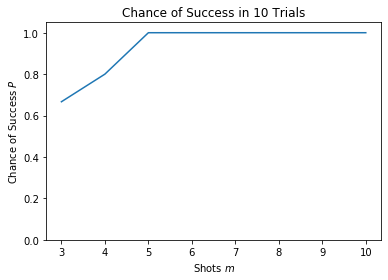

In [50]:
#Parameters for testing
# n value
n = 3
# matrix to use
matrix = matrix_3
# circuit to run (unnecessary for n=)
#  m value to start from
min_m = 3
#  m value to end at
max_m = 10
#  number of trials to perform for each m value
trials = 10
#  whether or not to test the transpiled circuit. This won't change the outcome
#   if we're running on a quantum computer already. If we're running on a simulator,
#   this helps us verify that the transpiled circuit still produces the same results
#   if no errors occur in the computation.
transpiled = False
#  the number of a values to test. This doesn't matter for n=3 and n=8,
#   for which we only have one a value, but if n=6, we have 16 to choose from. 
#   This is why we have two perform_experiment functions.
a_vals = 16

results = perform_experiment(n, min_m, max_m, backend=backend, trials_each = trials, transpiled = transpiled)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials'.format(trials))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')

Text(0, 0.5, 'Chance of Success $P$')

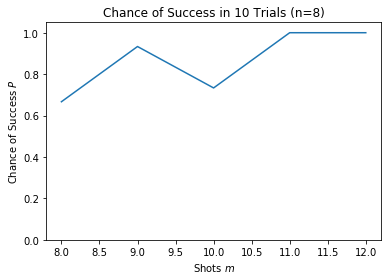

In [84]:
#Parameters for testing
# n value
n = 8
# matrix to use
matrix = matrix_8
#  m value to start from
min_m = 8
#  m value to end at
max_m = 12
#  number of trials to perform for each m value
trials = 10
#  whether or not to test the transpiled circuit. This won't change the outcome
#   if we're running on a quantum computer already. If we're running on a simulator,
#   this helps us verify that the transpiled circuit still produces the same results
#   if no errors occur in the computation.
transpiled = False
#  the number of a values to test. This doesn't matter for n=3 and n=8,
#   for which we only have one a value, but if n=6, we have 16 to choose from. 
#   This is why we have two perform_experiment functions.
a_vals = 16

results = perform_experiment(n, min_m, max_m, backend=backend, trials_each = trials, transpiled = transpiled)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials (n={})'.format(trials, n))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')

## 6. Simulating Noise
We now provide implementations for our noise simulations, utilizing superposition, phase, and combination noise. The parameters $\mathtt{phase\_noise}$ and $\mathtt{superposition\_noise}$ determine the maximum magnitude of their respective noise perturbations. If both are nonzero, we have combination noise. The $\mathtt{static}$ parameter determines whether the noise is static or not.

In [53]:
def build_noise_circuit(n, matrix, phase_noise=0, superposition_noise=0, static=True, barriers=False):
    input_register = QuantumRegister(n, 'input')
    output_register = QuantumRegister(n-1, 'output')
    creg = ClassicalRegister(n, 'creg')
    circuit = QuantumCircuit(input_register, output_register, creg)
    #U3 gate on every qubit in input register 
    #equivalent to H if both noises are zero
    ph_noise_val = np.random.normal(0, phase_noise)
    sup_noise_val = np.random.normal(0, superposition_noise)
    for i in range(n):
        circuit.u3(theta=np.pi/2+sup_noise_val, phi=ph_noise_val, lam=np.pi+ph_noise_val, q=i)
        if not static:
            ph_noise_val = np.random.uniform(-1, 1) * phase_noise
            sup_noise_val = np.random.uniform(-1, 1) * superposition_noise
    if barriers:
        circuit.barrier(input_register)
        circuit.barrier(output_register)   
    #function that Implements Uf with CNOT gates
    build_Uf(circuit, matrix)
    #Now measure the output qregister
    for i in range(n-1):
        circuit.measure(output_register[i], creg[i])
    # at this point, the qubits are in a superposition of exactly two states
    # so we apply H to every input qubit and them measure it
    #...except now it's noisy so we actually apply U3
    ph_noise_val = np.random.normal(0, phase_noise)
    sup_noise_val = np.random.normal(0, superposition_noise)
    for i in range(n):
        circuit.u3(theta=np.pi/2+sup_noise_val, phi=ph_noise_val, lam=np.pi+ph_noise_val, q=i)
        if not static:
            ph_noise_val = np.random.normal(-1, 1) * phase_noise
            sup_noise_val = np.random.normal(-1, 1) * superposition_noise
    if barriers:
        circuit.barrier(input_register)
        circuit.barrier(output_register)
    for i in range(n):
        circuit.measure(input_register[i], creg[i])
    return circuit

We also need to slightly modify the code to perform experiments so that noise values can be put into the circuits.

In [86]:
def perform_noise_experiment6(runs_min, runs_max, phase_noise=0, superposition_noise=0, static=True, 
                             a_val_num=16, backend=Aer.get_backend('qasm_simulator'), trials_each=10):
    shot_x = []
    success_y = []
    for shots in range(runs_min, runs_max+1):
        shot_x.append(shots)
        percentages = []
        for i in range(a_val_num):
            (a, a_matrix) = a_value_pairs[i]
            a_circuit = build_noise_circuit(6, a_matrix, 
                                      phase_noise=phase_noise, 
                                      superposition_noise=superposition_noise,
                                      static=static)
            percentages.append(test_accuracy(shots, a, a_circuit, backend=backend, trials=trials_each))
        success_y.append(np.mean(percentages))
    return (shot_x, success_y)

def perform_noise_experiment(n, runs_min, runs_max, phase_noise=0., superposition_noise = 0., a_val_num = 16,
                             backend=Aer.get_backend('qasm_simulator'), static=True, trials_each=10):
    if n == 6:
        return perform_noise_experiment6(runs_min, runs_max, phase_noise = phase_noise, superposition_noise = superposition_noise,
                                        backend = backend, static = static, trials_each = trials_each, a_val_num = a_val_num)
    shot_x = []
    successes_y = []
    if n == 3:
        expected_a = '111'
        matrix = matrix_3
    elif n == 8:
        expected_a = '10000001'
        matrix = matrix_8
    circuit = build_noise_circuit(n, matrix, phase_noise = phase_noise, superposition_noise = superposition_noise, static=static)
    for shots in range(runs_min, runs_max+1):
        shot_x.append(shots)
        successes_y.append(test_accuracy(shots, expected_a, circuit, backend=backend, trials=trials_each))        
    return (shot_x, successes_y)

And now we can perform an experiment with a noisy circuit!

Text(0, 0.5, 'Chance of Success $P$')

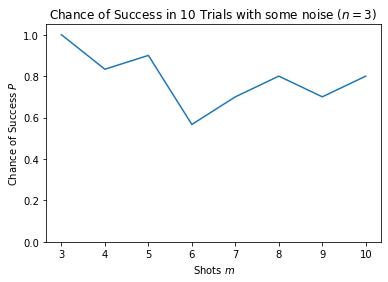

In [61]:
results = perform_noise_experiment(3, 3, 10, phase_noise = 0.1, superposition_noise = 0.1)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials with some noise ($n=3$)'.format(trials))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')

Text(0, 0.5, 'Chance of Success $P$')

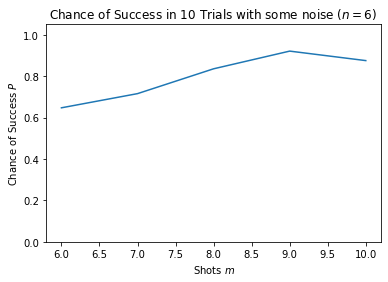

In [68]:
n = 6
min_m = 6
max_m = 10
results = perform_noise_experiment(n, min_m, max_m, phase_noise = 0.1, superposition_noise = 0.)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials with some noise ($n=6$)'.format(trials))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')

Text(0, 0.5, 'Chance of Success $P$')

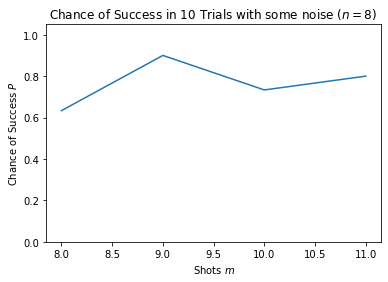

In [88]:
n = 8
min_m = 8
max_m = 11
results = perform_noise_experiment(n, min_m, max_m, phase_noise = 0., superposition_noise = 0.1)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials with some noise ($n=8$)'.format(trials))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')

## 7. Transpilation
Here we take a look at the circuits after being transpiled onto IBM quantum computers. This often results in many $cX$ gates being added, which we have found to be a significant source of errors. The $n=8$ case is specifically designed to minimize error introduced by transpilation.

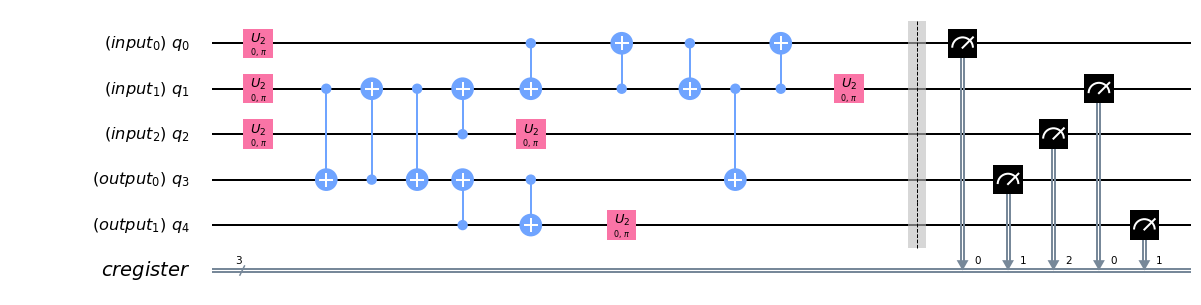

In [100]:
# transpile the n=3 circuit onto ibmq_ourense
circuit3_transpiled = transpile(build_circuit(3, matrix_3), backend5)
circuit3_transpiled.draw(output='mpl')

We can verify that the transpiled circuit still performs the correct function on the simulator. Note that the $\mathtt{backend}$ argument determines which backend the circuit will run on, whereas the $\mathtt{transpile\_backend}$ argument determines which backend the circuit will be transpiled according to. If $\mathtt{transpile\_backend}$ is not set, it defaults to the $\mathtt{qasm\_simulator}$, which performs no modifications to our circuits.

Text(0, 0.5, 'Chance of Success $P$')

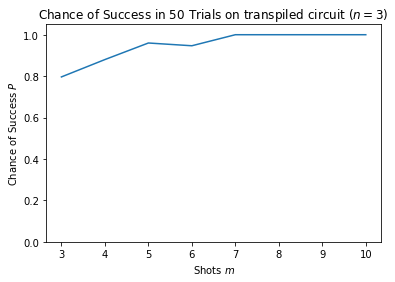

In [105]:
simulator = Aer.get_backend('qasm_simulator')
n=3
trials = 50
results = perform_experiment(3, 3, 10, backend=simulator, trials_each = trials, transpiled=True, transpile_backend = backend5)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials on transpiled circuit ($n=3$)'.format(trials))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')

We can do the same with the $n=6$ circuit, introducing an unholy amount of $cX$ gates:

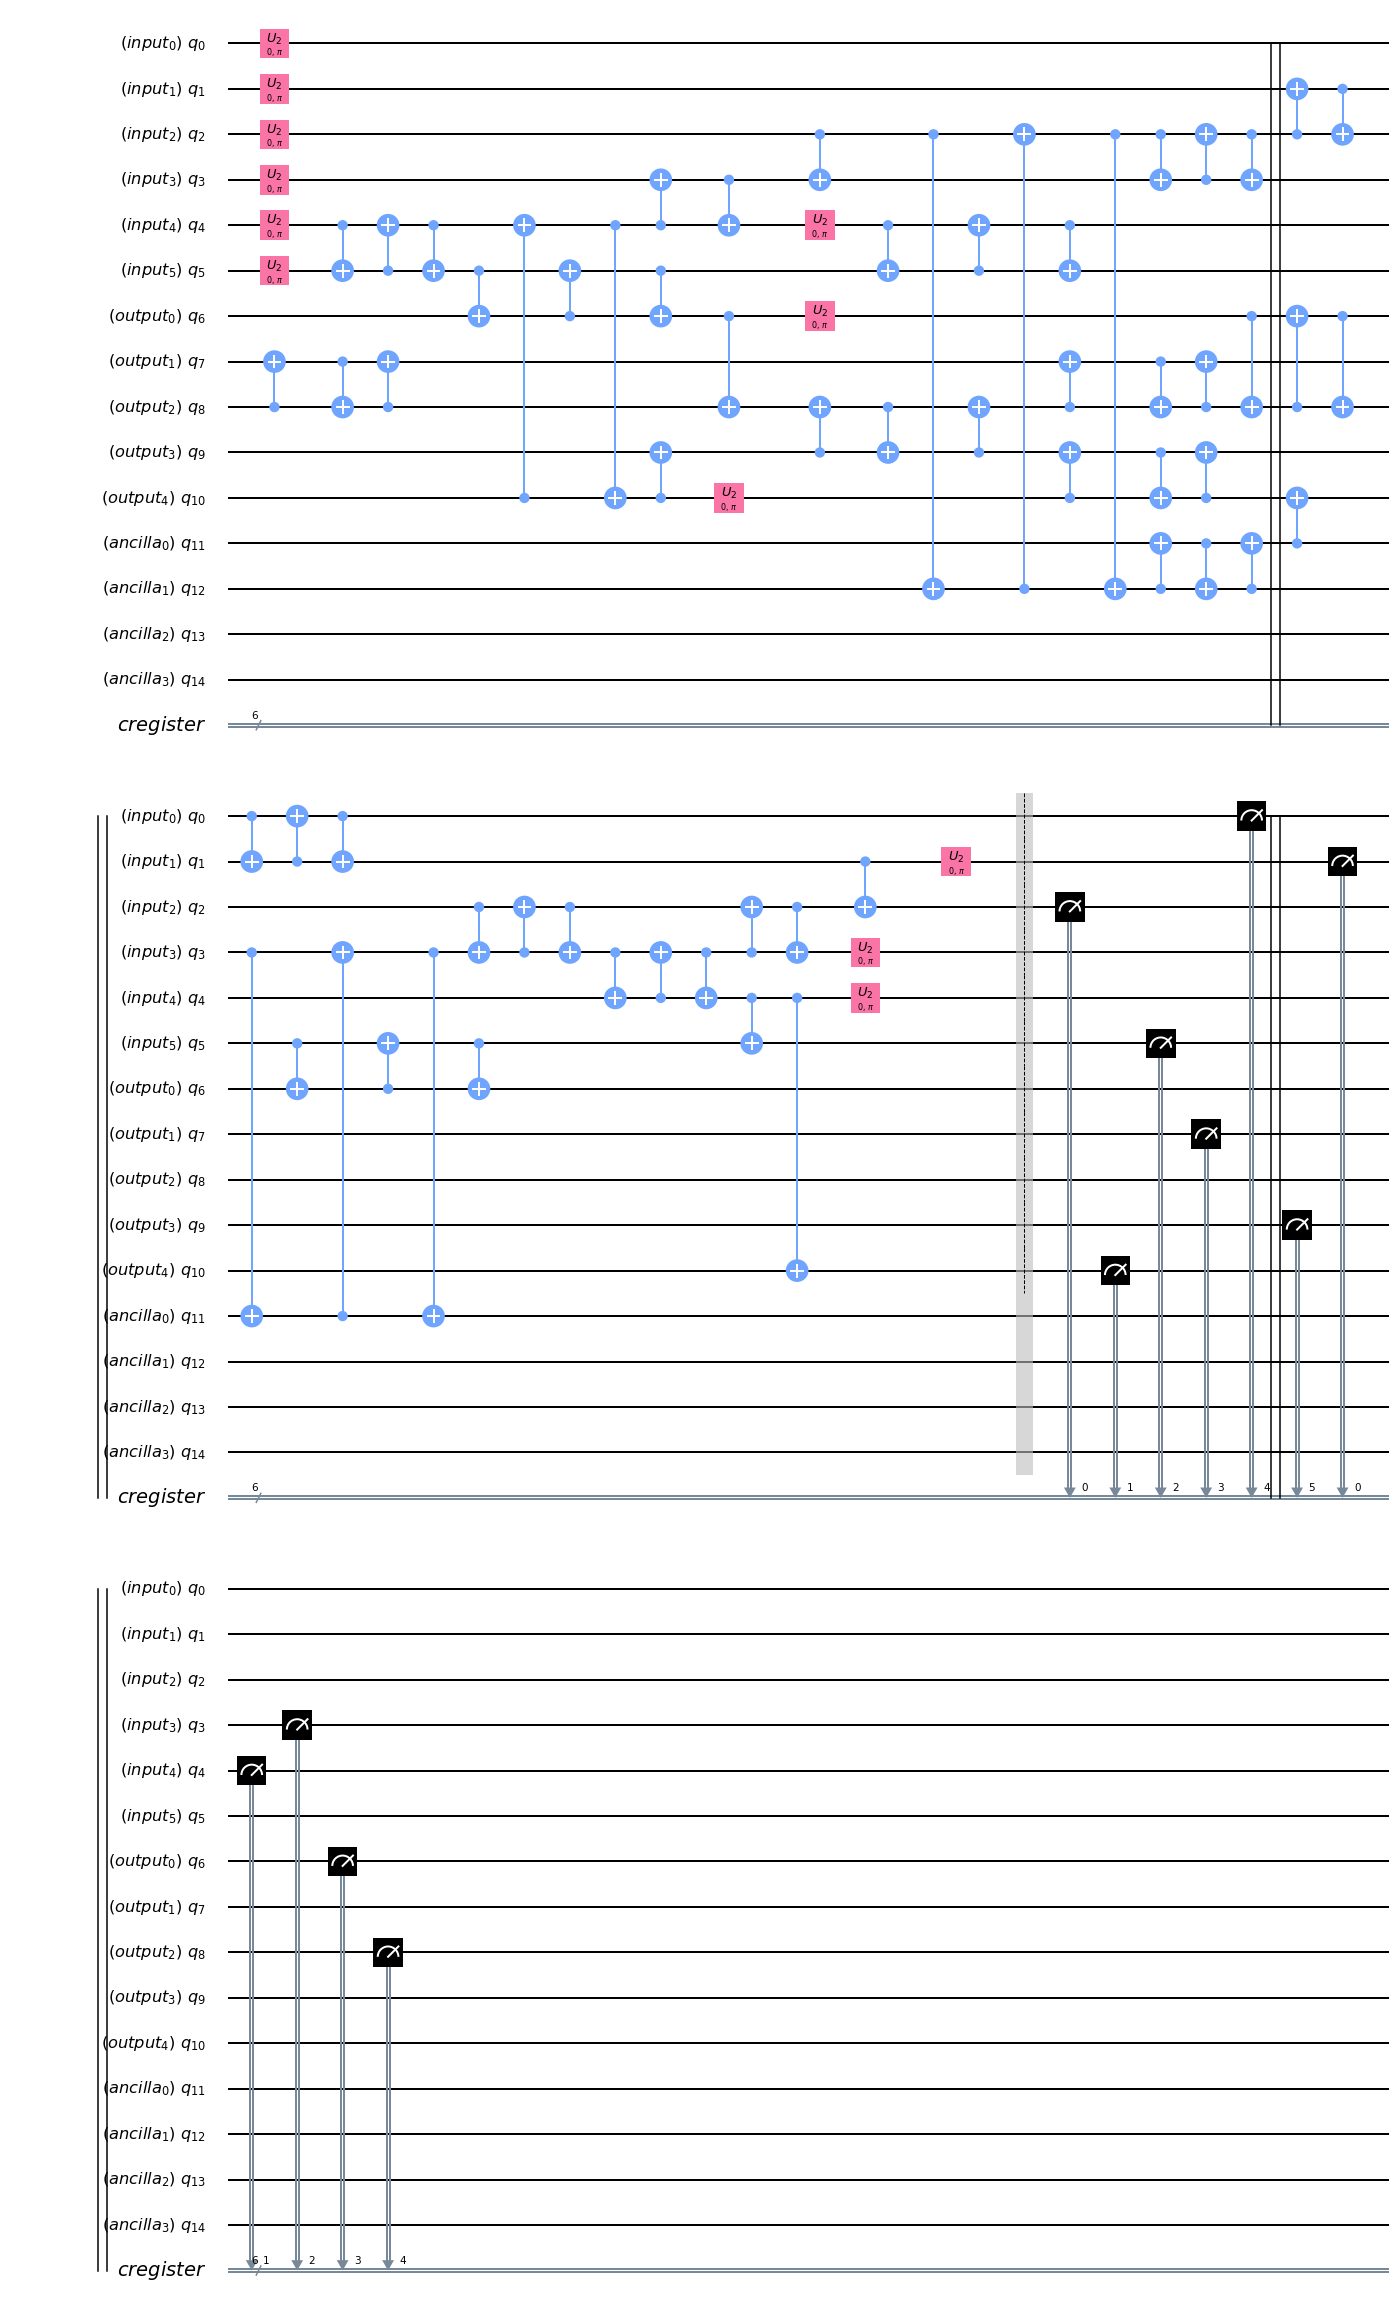

In [106]:
# transpile the n=6 circuit onto ibmq_16_melbourne
circuit6_transpiled = transpile(build_circuit(6, a_value_pairs[0][1]), backend)
circuit6_transpiled.draw(output='mpl')

Note that the circuit still performs its task as well as without transpilation in simulations.

Text(0, 0.5, 'Chance of Success $P$')

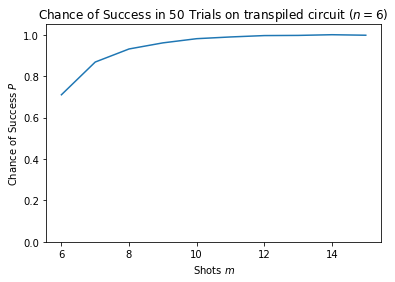

In [113]:
n=6
trials = 50
results = perform_experiment(6, 6, 15, backend=simulator, trials_each = trials, transpiled=True, transpile_backend = backend)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials on transpiled circuit ($n=6$)'.format(trials))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')

Finally, we can demonstrate the effectiveness of keeping the topology of the phyiscal quantum computer in mind with the $n=8$ circuit. If we transpile it without telling the transpiler which qubits in the circuit should correspond to specific qubits on $\mathtt{ibmq\_melbourne}$, we see a huge increase in the number of gates needed:

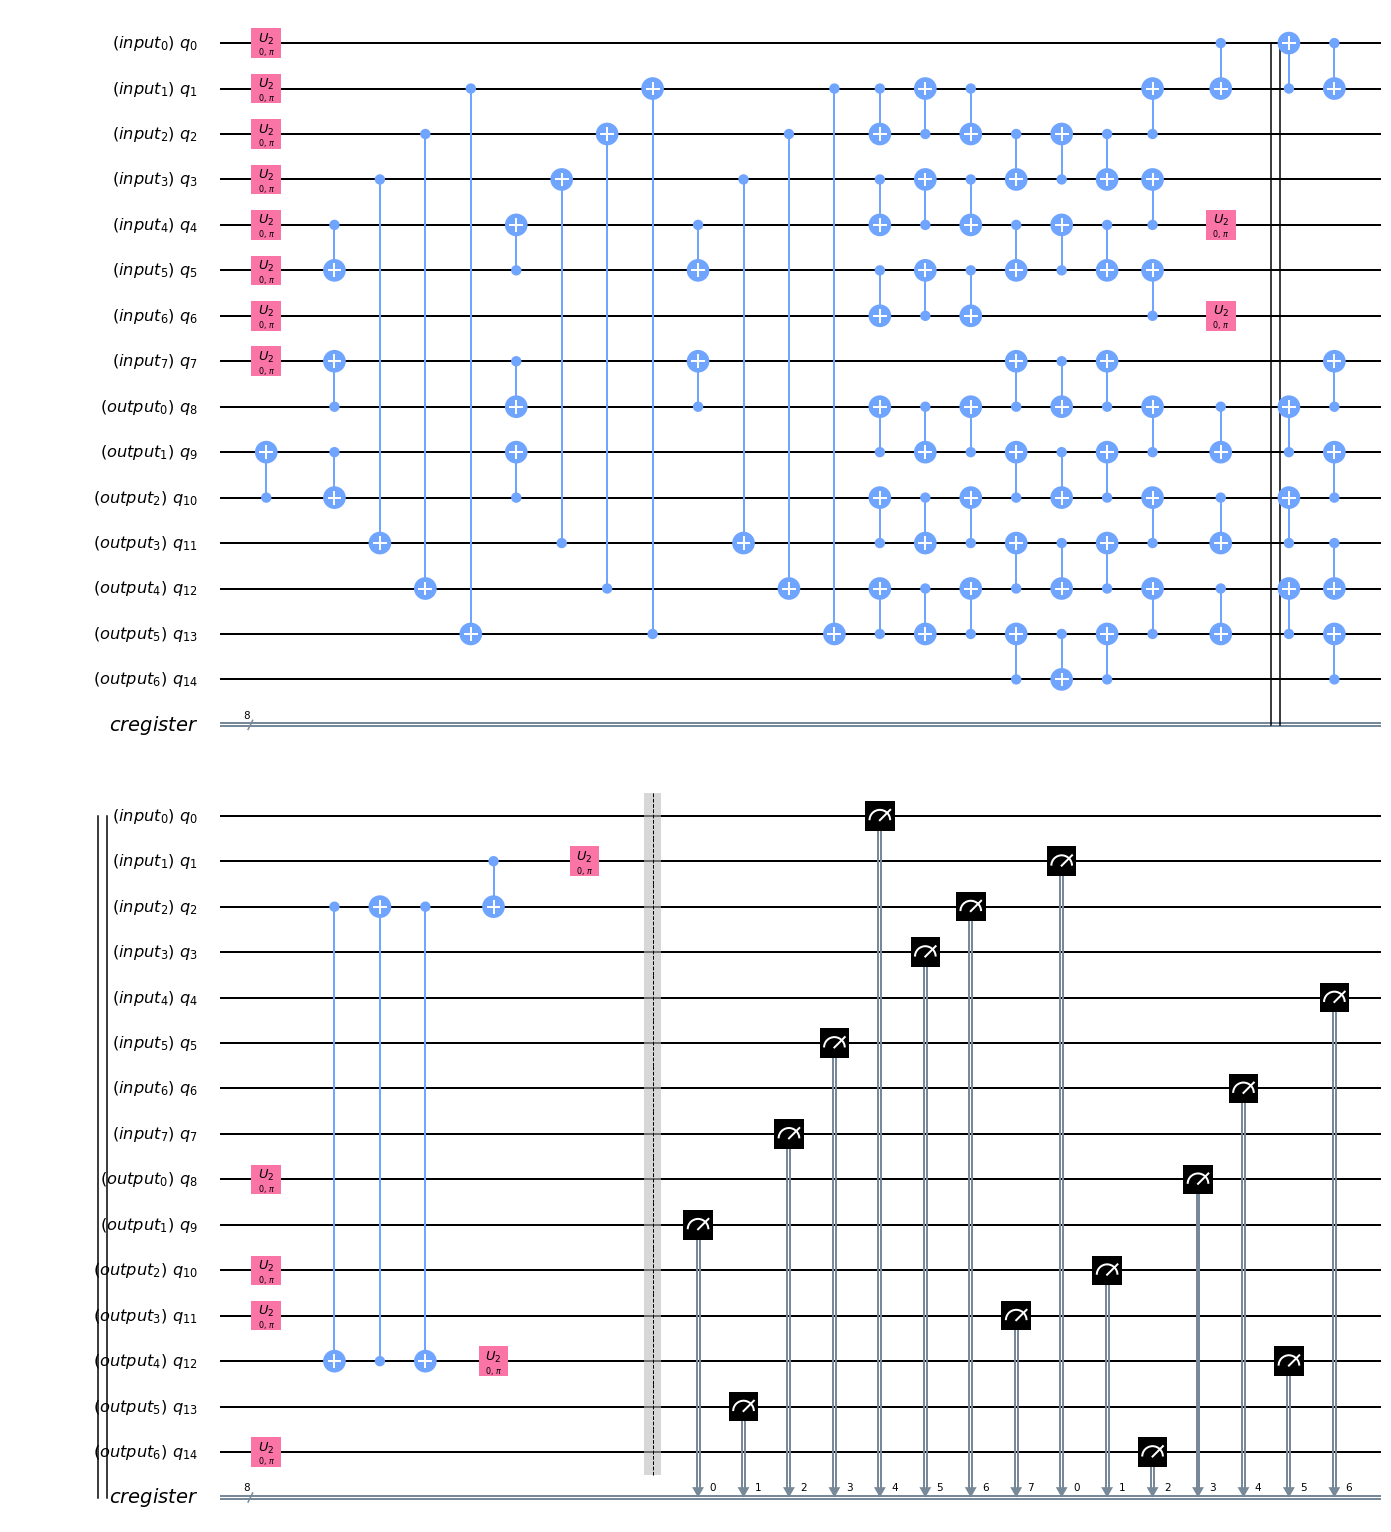

In [114]:
# transpile the n=8 circuit onto ibmq_16_melbourne
circuit8_transpiled_bad = transpile(build_circuit(8, matrix_8), backend)
circuit8_transpiled_bad.draw(output='mpl')

If we instead provide a specific assignment for the qubits to minimize state swaps (which is what the sequences of three $cX$ gates we see throughout the transpiled circuits do), zero additional $cX$ gates are needed!

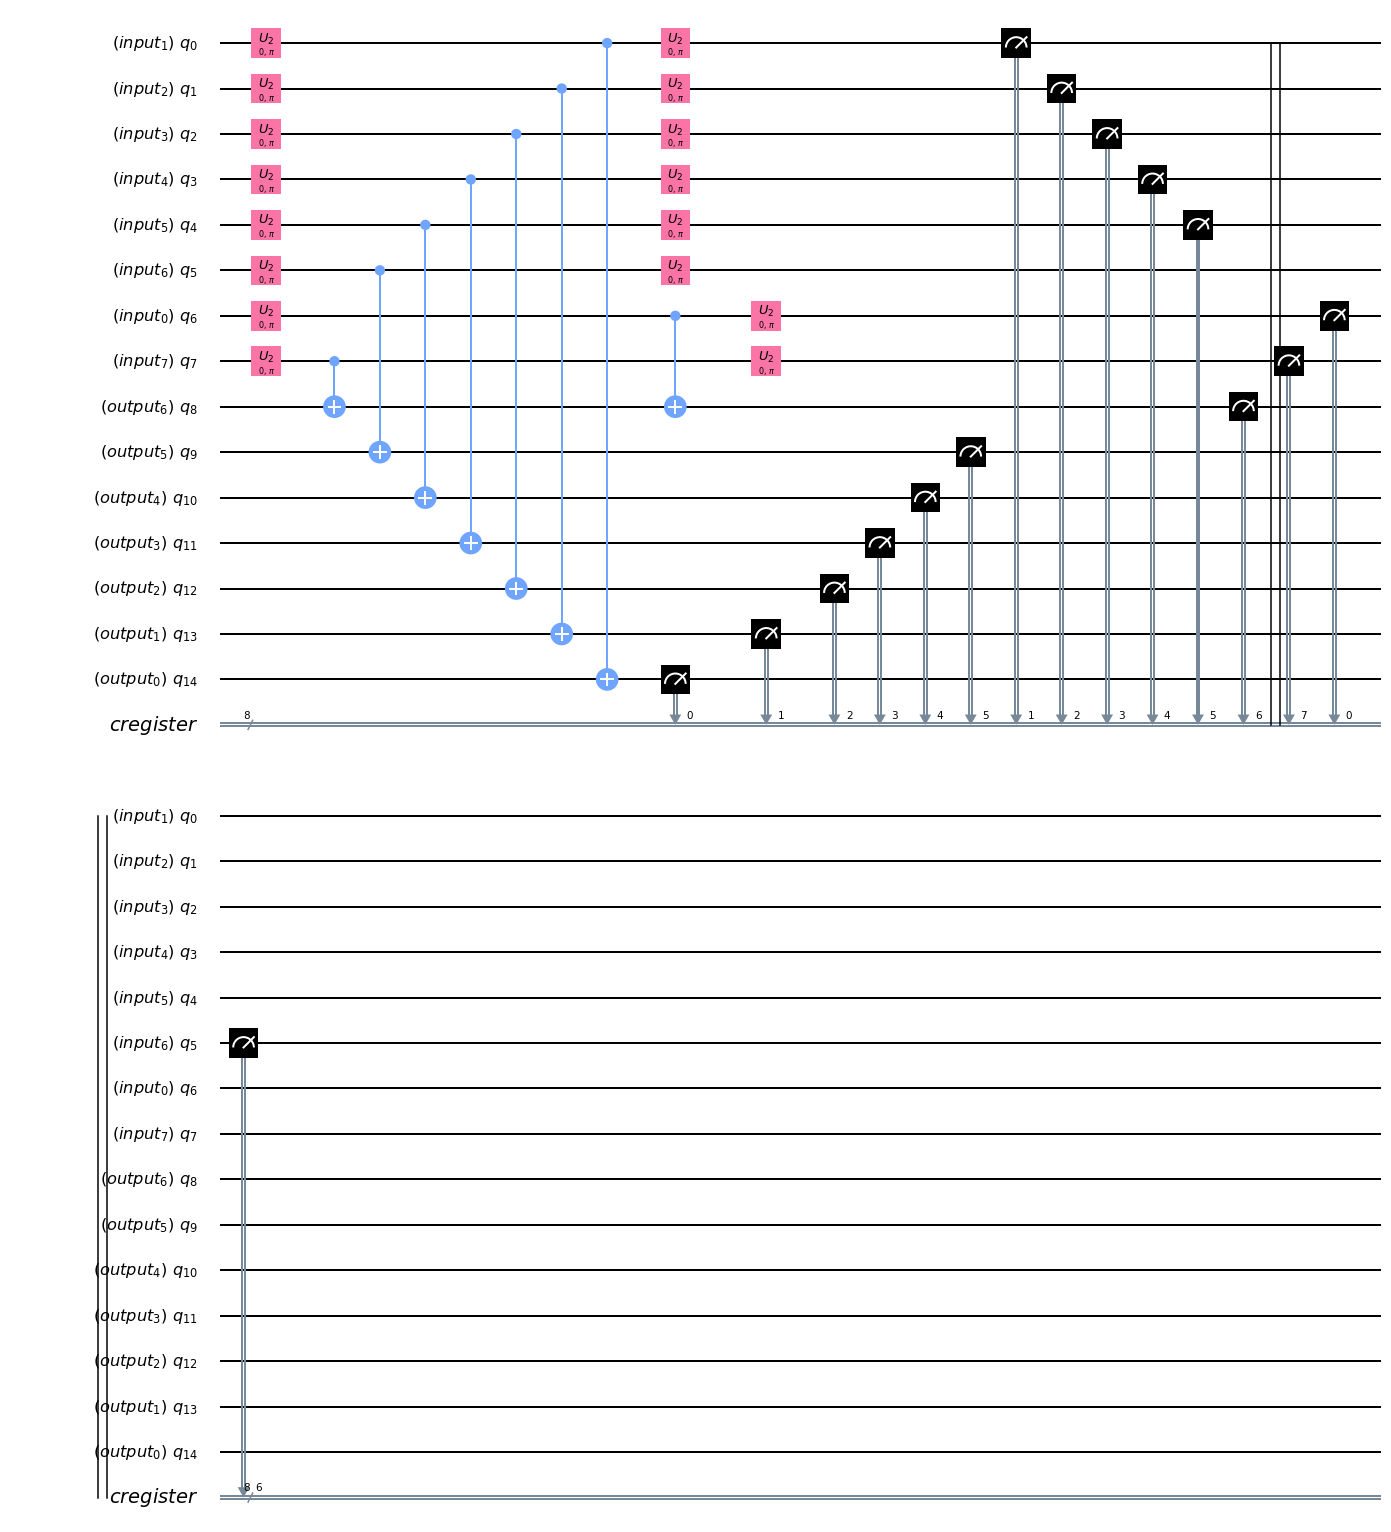

In [115]:
transpile(build_circuit(8, matrix_8), backend, initial_layout=[6,0,1,2,3,4,5,7,14,13,12,11,10,9,8]).draw(output='mpl')

Of course, this circuit still performs its task correctly in simulations:

Text(0, 0.5, 'Chance of Success $P$')

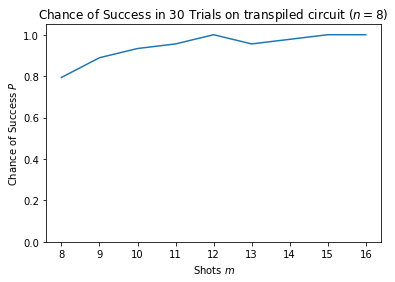

In [116]:
n=8
trials = 30
results = perform_experiment(8, 8, 16, backend=simulator, trials_each = trials, transpiled=True, transpile_backend = backend)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials on transpiled circuit ($n=8$)'.format(trials))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')